<a href="https://colab.research.google.com/github/stakunlena/ich_final_project/blob/main/03_product_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Продуктовый анализ

## Импорт библиотек и исходных данных

In [64]:
# Импортируем основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="Blues_d") # Устанавливаем единый стиль для всех диаграмм

# Загружаем исходные данные
import os
from google.colab import drive # Импортируем библиотеку для работы с Google Drive

# Подключаем Google Drive
drive.mount('/content/drive')

# Путь к папке с данными
base_path = '/content/drive/MyDrive/P. Project 07.11/csv/'
postfix = '20251103_0053' # чтобы задавать имена версий исходных файлов

# Загружаем данные
#df_contacts = pd.read_csv(base_path + 'df_contacts_clean_'+ postfix +'.csv', sep=";", encoding="utf-8-sig", parse_dates=["created_time", "modified_time"])
#df_calls = pd.read_csv(base_path + 'df_calls_clean_'+ postfix +'.csv', sep=";", encoding="utf-8-sig", parse_dates=["call_start_time"])
df_deals = pd.read_csv(base_path + 'df_deals_clean_'+ postfix +'.csv', sep=";", encoding="utf-8-sig", parse_dates=["created_time", "closing_date"])
df_spend = pd.read_csv(base_path + 'df_spend_clean_'+ postfix +'.csv', sep=";", encoding="utf-8-sig", parse_dates=["date"])

# Проверяем загрузку
#print(f"Contacts: {df_contacts.shape} | Calls: {df_calls.shape} | Deals: {df_deals.shape} | Spend: {df_spend.shape}")
print(f"Deals: {df_deals.shape} | Spend: {df_spend.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Deals: (21593, 25) | Spend: (19862, 12)


## Юнит-экономика по продуктам

In [65]:
# === 0. Целевые продукты ===
TARGET = {"digital marketing", "ux/ui design", "web developer"}

# === 1. Подготовка данных ===
df_deals["initial_amount_paid"] = pd.to_numeric(df_deals["initial_amount_paid"], errors="coerce").fillna(0)
df_deals["offer_total_amount"] = pd.to_numeric(df_deals["offer_total_amount"], errors="coerce").fillna(0)

# Булев флаг оплаты — по стадии
df_deals["payment_done"] = df_deals["stage"].str.lower().str.strip() == "payment done"

# Фильтрация по целевым продуктам
deals_t = df_deals[df_deals["product"].isin(TARGET)].copy()

# --- Оплаченные сделки ---
deals_paid = deals_t[deals_t["payment_done"]].copy()

# Поле идентификатора клиента
client_col = "contact_name" if "contact_name" in df_deals.columns else "contactid"

# === 2. Метрики по оплаченным сделкам ===
b_t_rev_aov = (
    deals_paid.groupby("product", as_index=False)
    .agg(
        t=("id", "count"),                     # число сделок
        b=(client_col, "nunique"),             # число клиентов
        revenue=("initial_amount_paid", "sum"),# выручка
        aov=("initial_amount_paid", "mean")    # средний чек
    )
)
b_t_rev_aov["apc"] = np.where(b_t_rev_aov["b"] > 0, b_t_rev_aov["t"] / b_t_rev_aov["b"], 0)

# === 3. CAC и AC ===
spend_by_camp = df_spend.groupby("campaign", as_index=False).agg(spend=("spend", "sum"))
leads_by_camp = df_deals.groupby("campaign", as_index=False).agg(leads=("id", "count"))

cac = spend_by_camp.merge(leads_by_camp, on="campaign", how="outer")
cac["spend"] = cac["spend"].fillna(0)
cac["leads"] = cac["leads"].fillna(0)
cac["cac_per_lead"] = np.where(cac["leads"] > 0, cac["spend"] / cac["leads"], 0)

prod_camp = (
    deals_t.groupby(["product", "campaign"], as_index=False)
    .agg(leads=("id", "count"))
    .merge(cac[["campaign", "cac_per_lead"]], on="campaign", how="left")
)
prod_camp["cac_per_lead"] = prod_camp["cac_per_lead"].fillna(0)
prod_camp["ac_attributed"] = prod_camp["leads"] * prod_camp["cac_per_lead"]

ac_by_product = (
    prod_camp.groupby("product", as_index=False)
    .agg(ac_total=("ac_attributed", "sum"))
)

# === 4. UA (все потенциальные сделки по продукту) ===
ua_by_product = []
for p in TARGET:
    mask = (
        (df_deals["product"].isna()) |  # без продукта
        #(df_deals["product"] == p)      # сам продукт
        (df_deals["product"] != p)
    )
    ua = df_deals.loc[mask].shape[0]
    ua_by_product.append({"product": p, "ua": ua})
ua_by_product = pd.DataFrame(ua_by_product)

# === 5. Объединяем метрики ===
prod = (
    ua_by_product
    .merge(b_t_rev_aov, on="product", how="left")
    .merge(ac_by_product, on="product", how="left")
)

# === 6. Расчёт юнит-экономики ===
prod["ac"] = prod["ac_total"].fillna(0)
prod["c1"] = np.where(prod["ua"] > 0, prod["b"] / prod["ua"], 0.0)
prod["cogs_per_client"] = 0.0
prod["cltv"] = (prod["aov"].fillna(0) - prod["cogs_per_client"]) * prod["apc"]
prod["ltv"] = prod["cltv"] * prod["c1"]
prod["cpa"] = np.where(prod["ua"] > 0, prod["ac_total"] / prod["ua"], 0.0)
prod["cm"] = (prod["cltv"] * prod["c1"] - prod["cpa"]) * prod["ua"]

# === 7. Финальная таблица ===
cols = ["product","ua","b","t","apc","c1","ac","cpa","revenue","aov","cltv","ltv","cm"]
prod = prod[cols].sort_values("revenue", ascending=False)

# === 8. Форматирование вывода ===
int_cols = prod.select_dtypes(include=["int64"]).columns
float_cols = prod.select_dtypes(include=["float64"]).columns

format_dict = {}
format_dict.update({col: "{:,.0f}" for col in int_cols})
format_dict.update({
    "apc": "{:,.3f}",
    "ac": "{:,.2f}",
    "c1": "{:,.4f}",
    "aov": "{:,.2f}",
    "cpa": "{:,.2f}",
    "cltv": "{:,.2f}",
    "ltv": "{:,.2f}",
    "cm": "{:,.2f}",
    "revenue": "{:,.2f}"
})

styled = (
    prod.style
    .format(format_dict)
    .background_gradient(subset=["revenue"], cmap="Greens")
    .background_gradient(subset=["cm"], cmap="Blues")
    .set_caption("Юнит-экономика по продуктам (учтены только сделки со stage='payment done')")
    .hide(axis="index")
)

display(styled)

product,ua,b,t,apc,c1,ac,cpa,revenue,aov,cltv,ltv,cm
digital marketing,"19,603",458,474,1.035,0.0234,"10,446.56",0.53,"531,900.00","1,122.15","1,161.35",27.13,"521,453.44"
ux/ui design,"20,571",221,229,1.036,0.0107,"4,812.71",0.23,"275,100.00","1,201.31","1,244.80",13.37,"270,287.29"
web developer,"21,018",131,137,1.046,0.0062,"3,482.41",0.17,"143,350.00","1,046.35","1,094.27",6.82,"139,867.59"


## Поиск точек роста

In [66]:
def analyze_growth_drivers(prod: pd.DataFrame, product_name: str, growth_rate: float = 0.05):
    """
    Анализ чувствительности CM к росту ключевых метрик юнит-экономики.
    Подсвечивает изменённые драйверы красным шрифтом.

    Параметры:
    -----------
    prod : pd.DataFrame
        Таблица юнит-экономики (результат финального расчета prod)
    product_name : str
        Название продукта для анализа, например 'web developer'
    growth_rate : float, default=0.05
        Темп роста (например, 0.05 = +5%)

    Возвращает:
    ------------
    styled : pd.io.formats.style.Styler
        Таблица сценариев изменения CM с выделением наилучшего драйвера роста
        и подсветкой изменённых параметров
    """

    # === 1. Извлекаем базовые значения ===
    base = prod.loc[prod["product"] == product_name].copy()
    if base.empty:
        raise ValueError(f"Продукт '{product_name}' не найден в таблице.")

    UA = base["ua"].values[0]
    B = base["b"].values[0]
    AOV = base["aov"].values[0]
    APC = base["apc"].values[0]
    CPA = base["cpa"].values[0]
    C1 = base["c1"].values[0]
    CLTV = base["cltv"].values[0]
    CM = base["cm"].values[0]

    # === 2. Формула расчета CM ===
    def calc_cm(ua, c1, aov, apc, cpa, cogs=0):
        cltv = (aov - cogs) * apc
        cm = (cltv * c1 - cpa) * ua
        return cltv, cm

    # === 3. Сценарии роста ===
    scenarios = []
    #scenarios.append(["base", "—", UA, C1, AOV, APC, CPA, *calc_cm(UA, C1, AOV, APC, CPA)])
    #scenarios.append([f"ua+{int(growth_rate*100)}%", "UA", UA*(1+growth_rate), C1, AOV, APC, CPA, *calc_cm(UA*(1+growth_rate), C1, AOV, APC, CPA)])
    #scenarios.append([f"c1+{int(growth_rate*100)}%", "C1", UA, C1*(1+growth_rate), AOV, APC, CPA, *calc_cm(UA, C1*(1+growth_rate), AOV, APC, CPA)])
    #scenarios.append([f"aov+{int(growth_rate*100)}%", "AOV", UA, C1, AOV*(1+growth_rate), APC, CPA, *calc_cm(UA, C1, AOV*(1+growth_rate), APC, CPA)])
    #scenarios.append([f"apc+{int(growth_rate*100)}%", "APC", UA, C1, AOV, APC*(1+growth_rate), CPA, *calc_cm(UA, C1, AOV, APC*(1+growth_rate), CPA)])
    #scenarios.append([f"cpa-{int(growth_rate*100)}%", "CPA", UA, C1, AOV, APC, CPA*(1-growth_rate), *calc_cm(UA, C1, AOV, APC, CPA*(1-growth_rate))])

    scenarios.append(["base", UA, C1, AOV, APC, CPA, *calc_cm(UA, C1, AOV, APC, CPA)])
    scenarios.append(["UA", UA*(1+growth_rate), C1, AOV, APC, CPA, *calc_cm(UA*(1+growth_rate), C1, AOV, APC, CPA)])
    scenarios.append(["C1", UA, C1*(1+growth_rate), AOV, APC, CPA, *calc_cm(UA, C1*(1+growth_rate), AOV, APC, CPA)])
    scenarios.append(["AOV", UA, C1, AOV*(1+growth_rate), APC, CPA, *calc_cm(UA, C1, AOV*(1+growth_rate), APC, CPA)])
    scenarios.append(["APC", UA, C1, AOV, APC*(1+growth_rate), CPA, *calc_cm(UA, C1, AOV, APC*(1+growth_rate), CPA)])
    scenarios.append(["CPA", UA, C1, AOV, APC, CPA*(1-growth_rate), *calc_cm(UA, C1, AOV, APC, CPA*(1-growth_rate))])

    # === 4. Таблица результатов ===
    #df = pd.DataFrame(scenarios, columns=[
    #    "scenario", "changed_driver", "ua", "c1", "aov", "apc", "cpa", "cltv", "cm"
    #])

    df = pd.DataFrame(scenarios, columns=[
        "changed_driver", "ua", "c1", "aov", "apc", "cpa", "cltv", "cm"
    ])

    # прирост CM (%)
#    base_cm = df.loc[df["scenario"] == "base", "cm"].values[0]
#    df["cm_growth_abs"] = df["cm"] - base_cm
#    df["cm_growth_pct"] = np.where(base_cm != 0, (df["cm"] / base_cm - 1) * 100, 0)
#    df["is_best"] = df["cm"] == df["cm"].max()

    # прирост CM (%)
    base_cm = df.loc[df["changed_driver"] == "base", "cm"].values[0]
    df["cm_growth_abs"] = df["cm"] - base_cm
    df["cm_growth_pct"] = np.where(base_cm != 0, (df["cm"] / base_cm - 1) * 100, 0)
    df["is_best"] = df["cm"] == df["cm"].max()

    # === 5. Форматирование ===
    format_dict = {
        "ua": "{:,.0f}",
        "c1": "{:,.4f}",
        "aov": "{:,.2f}",
        "apc": "{:,.3f}",
        "cpa": "{:,.3f}",
        "cltv": "{:,.2f}",
        "cm": "{:,.2f}",
        "cm_growth_abs": "{:,.2f}",
        "cm_growth_pct": "{:,.2f}%"
    }

    # === 6. Стилизация таблицы ===
    def highlight_changed(val, changed_driver):
        """Подсвечивает красным изменённые параметры."""
        if changed_driver in ["UA", "C1", "AOV", "APC", "CPA"]:
            # Проверяем, соответствует ли текущий столбец драйверу роста
            col_name = {
                "UA": "ua", "C1": "c1", "AOV": "aov", "APC": "apc", "CPA": "cpa"
            }[changed_driver]
            return f"color: red; font-weight: 600;"
        return ""

    styled = (
        df.style
        .format(format_dict)
        .apply(lambda col: [
            "color: red; font-weight: 600;" if df.iloc[i]["changed_driver"].lower() in col.name.lower()
            else "" for i in range(len(df))
        ], subset=["ua", "c1", "aov", "apc", "cpa"])
        #.background_gradient(subset=["cm"], cmap="Blues")
        .highlight_max(subset=["cm"], color="lightgreen")
        .set_caption(f"Точки роста для продукта «{product_name}» при изменении драйверов на {int(growth_rate*100)}%")
        .hide(axis="index")
    )

    return styled


In [67]:
styled_growth = analyze_growth_drivers(prod, "digital marketing", growth_rate=0.05)
display(styled_growth)

changed_driver,ua,c1,aov,apc,cpa,cltv,cm,cm_growth_abs,cm_growth_pct,is_best
base,"19,603",0.0234,"1,122.15",1.035,0.533,"1,161.35","521,453.44",0.00,0.00%,False
UA,"20,583",0.0234,"1,122.15",1.035,0.533,"1,161.35","547,526.11","26,072.67",5.00%,False
C1,"19,603",0.0245,"1,122.15",1.035,0.533,"1,161.35","548,048.44","26,595.00",5.10%,True
AOV,"19,603",0.0234,"1,178.26",1.035,0.533,"1,219.42","548,048.44","26,595.00",5.10%,True
APC,"19,603",0.0234,"1,122.15",1.087,0.533,"1,219.42","548,048.44","26,595.00",5.10%,False
CPA,"19,603",0.0234,"1,122.15",1.035,0.506,"1,161.35","521,975.77",522.33,0.10%,False


In [68]:
styled_growth = analyze_growth_drivers(prod, "ux/ui design", growth_rate=0.05)
display(styled_growth)

changed_driver,ua,c1,aov,apc,cpa,cltv,cm,cm_growth_abs,cm_growth_pct,is_best
base,"20,571",0.0107,"1,201.31",1.036,0.234,"1,244.80","270,287.29",0.00,0.00%,False
UA,"21,600",0.0107,"1,201.31",1.036,0.234,"1,244.80","283,801.66","13,514.36",5.00%,False
C1,"20,571",0.0113,"1,201.31",1.036,0.234,"1,244.80","284,042.29","13,755.00",5.09%,True
AOV,"20,571",0.0107,"1,261.38",1.036,0.234,"1,307.04","284,042.29","13,755.00",5.09%,True
APC,"20,571",0.0107,"1,201.31",1.088,0.234,"1,307.04","284,042.29","13,755.00",5.09%,True
CPA,"20,571",0.0107,"1,201.31",1.036,0.222,"1,244.80","270,527.93",240.64,0.09%,False


In [69]:
styled_growth = analyze_growth_drivers(prod, "web developer", growth_rate=0.05)
display(styled_growth)

changed_driver,ua,c1,aov,apc,cpa,cltv,cm,cm_growth_abs,cm_growth_pct,is_best
base,"21,018",0.0062,"1,046.35",1.046,0.166,"1,094.27","139,867.59",0.00,0.00%,False
UA,"22,069",0.0062,"1,046.35",1.046,0.166,"1,094.27","146,860.97","6,993.38",5.00%,False
C1,"21,018",0.0065,"1,046.35",1.046,0.166,"1,094.27","147,035.09","7,167.50",5.12%,True
AOV,"21,018",0.0062,"1,098.67",1.046,0.166,"1,148.99","147,035.09","7,167.50",5.12%,False
APC,"21,018",0.0062,"1,046.35",1.098,0.166,"1,148.99","147,035.09","7,167.50",5.12%,True
CPA,"21,018",0.0062,"1,046.35",1.046,0.157,"1,094.27","140,041.71",174.12,0.12%,False


## Формулировка HADI-циклов

**HADI-1. Рост конверсии (C1)**

| Этап | Формулировка |
|------|---------------|
| **Hypothesis (H)** | Внедрение автоматического звонка менеджера в течение **10 минут** после заявки увеличит конверсию в оплату на **7 %**. |
| **Action (A)** | Настроить автоматическое уведомление в CRM: при поступлении новой заявки менеджеру ставится задача «позвонить в течение 10 минут». Подготовить и внедрить короткий скрипт «быстрого первого касания». |
| **Data (D)** | Срок теста — 2 недели. Сравниваются две группы лидов: до внедрения и после. Метрика — конверсия из лида в оплату (**C1**). Цель — прирост **≥ 7 %**. |
| **Insight (I)** | Гипотеза подтверждается, если конверсия в оплату выросла не менее чем на 7 % при сохранении стабильного объёма лидов. Если прирост < 7 % — гипотеза отвергается. |

---

**HADI-2. Рост среднего чека (AOV)**

| Этап | Формулировка |
|------|---------------|
| **Hypothesis (H)** | Введение возможности **оплаты курса в рассрочку на 3 месяца без переплаты** повысит средний чек на **8 %**. |
| **Action (A)** | Добавить опцию «Оплата курса в рассрочку на 3 месяца» на странице оплаты и в письмах после регистрации. Провести A/B-тест на новых студентах. |
| **Data (D)** | Срок теста — 4 недели. Отслеживать долю рассрочек, средний чек (**AOV**) и общую конверсию. Цель — прирост **AOV ≥ 8 %** при снижении конверсии не более чем на 1 п.п. |
| **Insight (I)** | Гипотеза подтверждается, если средний чек вырос не менее чем на 8 % при стабильной или улучшенной конверсии; иначе — отклоняется. |


## Формулировка условий проведения A/B тестов для HADI циклов

**HADI-1. Рост конверсии (C1)**

| Параметр | Описание |
|---|---|
| Гипотеза | Внедрение автоматического звонка менеджера в течение **10 минут** после заявки увеличит конверсию в оплату (**C1**) на **7%**. |
| Нулевая гипотеза | Звонок менеджера в течение **10 минут** после заявки не влияет на конверсию в оплату (**C1_B ≤ C1_A**). |
| Условия проведения A-теста | Группа **A** — текущий процесс (без обязательного звонка в течение **10 минут** после заявки). Случайное распределение 50% новых лидов. Длительность: **2 недели**. Каналы трафика — те же, что в группе B. Исключения: повторные лиды за 60 дней. Минимум: **800 лидов** или **≥200 оплат** в группе (что наступит позже). |
| Условия проведения B-теста | Группа **B** — менеджер обязан позвонить не позднее 10 минут после заявки (таск в CRM + скрипт «первого касания»). Случайное распределение 50% новых лидов. Длительность: **2 недели**. Те же каналы, те же исключения. Минимум: **800 лидов** или **≥200 оплат**. |
| Метрика для отслеживания | **Первичная:** C1 (оплаты / лиды). **Вспомогательные:** время до первого контакта (TTFC), доля контактов ≤10 мин, число дозвонов, **CPA**. |
| Граница подтверждения гипотезы | Гипотеза подтверждается, если **C1_B ≥ C1_A × 1.07** и различие статистически значимо. |
| Уровень значимости | **α = 0.05** (95% ДИ). |

---

**HADI-2. Рост среднего чека (AOV)**

| Параметр | Описание |
|---|---|
| Гипотеза | Введение возможности **оплаты курса в рассрочку на 3 месяца без переплаты** повысит средний чек (**AOV**) на **8%**. |
| Нулевая гипотеза (H₀) | Предложение рассрочки не увеличивает средний чек (**AOV_B ≤ AOV_A**). |
| Условия проведения A-теста | Группа **A** — стандартная оплата (без предложения рассрочки). Рандом 50% новых чек-аутов. Длительность: **4 недели**. Исключения: повторные покупки по этому же курсу. Минимум: **300 оплат** в группе. |
| Условия проведения B-теста | Группа **B** — на странице оплаты показывается опция «Рассрочка на 3 месяца без переплаты». Рандом 50% новых чек-аутов. Длительность: **4 недели**. Те же исключения. Минимум: **300 оплат**. |
| Метрика для отслеживания | **Первичная:** AOV (доход/число оплат). **Вспомогательные** конверсия в оплату, доля рассрочки, просрочки платежей. |
| Граница подтверждения гипотезы | Гипотеза подтверждается, если **AOV_B ≥ AOV_A × 1.08**, различие статистически значимо |
| Уровень значимости | **α = 0.05** (95% ДИ). |


### Дерево метрик и поток формирования маржинальной прибыли (CM-модель)

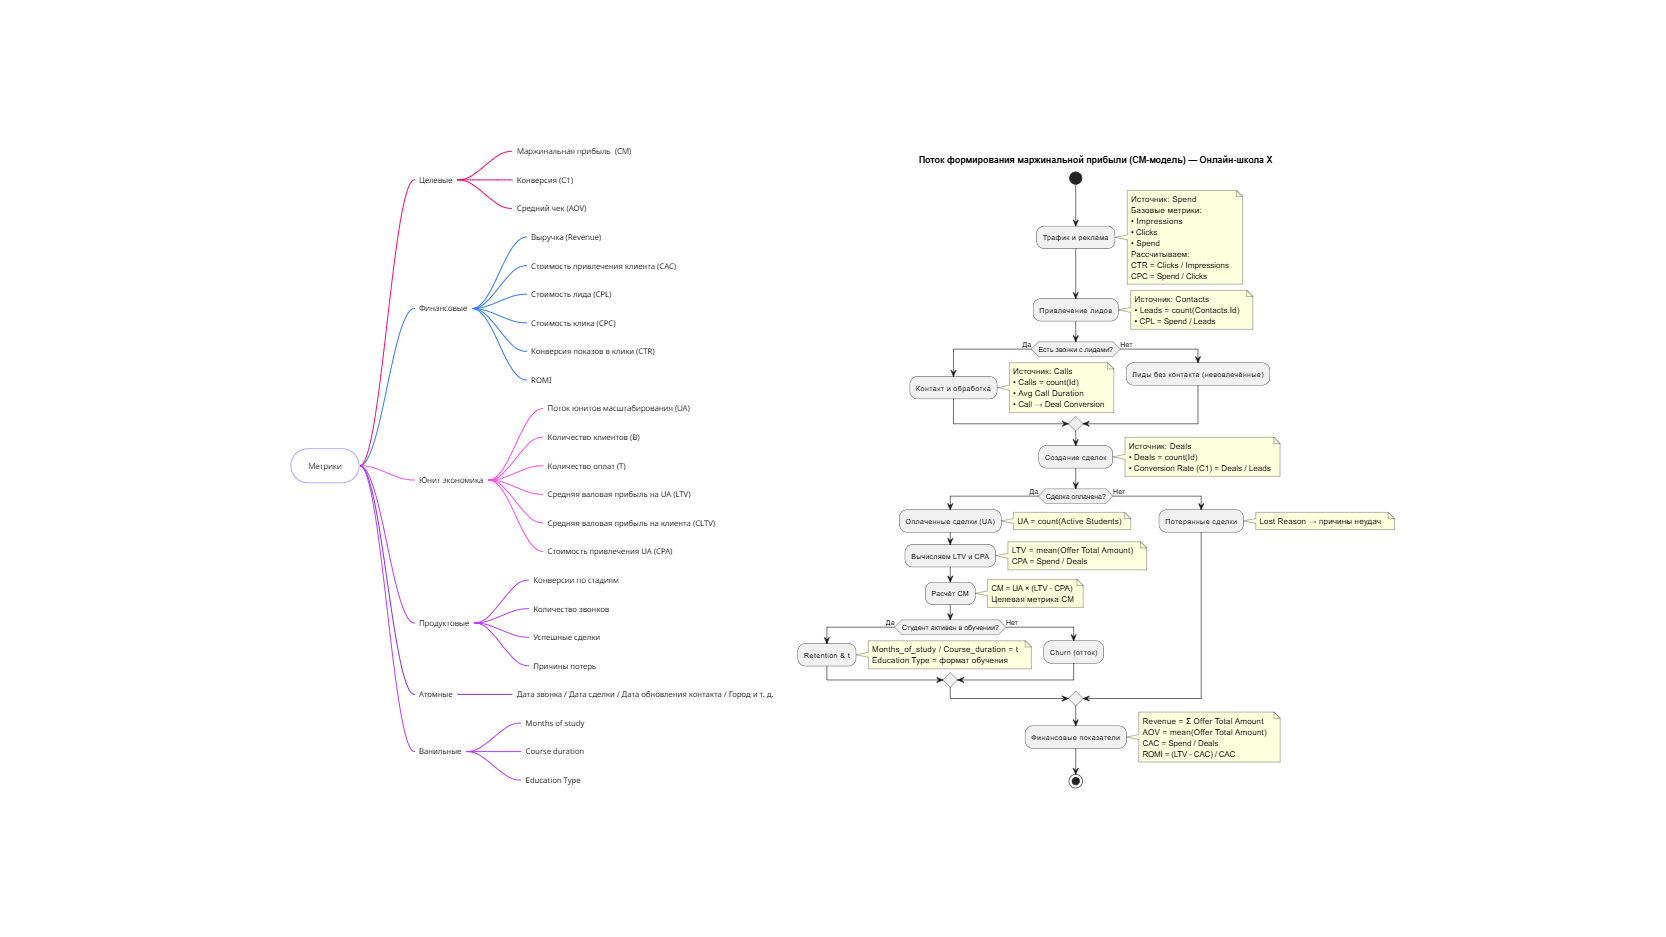

### Расчет репрезентативной выборки и оценка времени проведения A/B тестов

In [95]:
from scipy.stats import norm

def analyze_ab_test_feasibility(
    df_deals: pd.DataFrame,
    target_product: str,
    uplift_c1: float = 0.07,
    uplift_aov: float = 0.08,
    alpha: float = 0.05,
    power: float = 0.8,
    test_period_days: int = 14
) -> pd.DataFrame:
    """
    Анализ возможности проведения A/B-тестов для выбранного продукта.

    Параметры
    ----------
    df_deals : pd.DataFrame
        Датафрейм с CRM-данными (обязательно должны быть поля:
        'product', 'stage', 'created_time', 'initial_amount_paid').
    target_product : str
        Название продукта (например, 'digital marketing').
    uplift_c1 : float, optional
        Ожидаемый прирост конверсии (по умолчанию 7%).
    uplift_aov : float, optional
        Ожидаемый прирост среднего чека (по умолчанию 8%).
    alpha : float, optional
        Уровень значимости теста (по умолчанию 0.05).
    power : float, optional
        Статистическая мощность теста (по умолчанию 0.8).
    test_period_days : int, optional
        Длительность теста (по умолчанию 14 дней).

    Возвращает
    ----------
    pd.DataFrame
        Таблица с результатами анализа возможности проведения A/B-тестов.
    """

    # === 1. Подготовка данных ===
    df = df_deals.copy()
    df["created_time"] = pd.to_datetime(df["created_time"], errors="coerce")
    df["payment_done"] = df["stage"].str.lower().str.strip() == "payment done"

    # Подмножество по целевому продукту
    product_subset = df[df["product"] == target_product]

    # === 2. Расчет базовых метрик ===
    # Потенциальная аудитория (все сделки, кроме текущего продукта и без продукта)
    total_ua = df[(df["product"] != target_product) | (df["product"].isna())].shape[0]

    # Общее количество лидов и оплат по целевому продукту
    leads_total = product_subset.shape[0]
    pays_total = product_subset["payment_done"].sum()
    conv_rate = pays_total / leads_total if leads_total > 0 else 0

    # Средний чек (AOV) и коэффициент вариации (CV)
    aov_vals_all = product_subset["initial_amount_paid"].fillna(0)
    aov = aov_vals_all.mean()
    cv = aov_vals_all.std(ddof=1) / aov if aov > 0 else np.nan

    # === 3. Параметры теста ===
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    # --- Тест C1 (по конверсии) ---
    p1 = conv_rate if conv_rate > 0 else 0.09
    p2 = p1 * (1 + uplift_c1)
    p_bar = (p1 + p2) / 2
    n_c1 = ((z_alpha * np.sqrt(2 * p_bar * (1 - p_bar)) +
             z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2) / (p2 - p1) ** 2
    n_c1_total = n_c1 * 2

    # --- Тест AOV (по среднему доходу на лида) ---
    delta_aov = aov * uplift_aov
    sigma_aov = cv * aov
    n_aov = 2 * (z_alpha + z_beta) ** 2 * (sigma_aov ** 2) / (delta_aov ** 2)
    n_aov_total = n_aov * 2

    # === 4. Проверка выполнимости ===
    # Определяем длительность наблюдений в днях
    period_days_total = (df["created_time"].max() - df["created_time"].min()).days
    avg_daily_leads = total_ua / period_days_total if period_days_total > 0 else np.nan
    potential_leads = avg_daily_leads * test_period_days

    can_run_c1 = potential_leads >= n_c1_total
    can_run_aov = potential_leads >= n_aov_total

    # === 5. Итоговая таблица ===
    summary = pd.DataFrame([
        {
            "Тест": "C1 (конверсия звонков ≤10 мин)",
            "Целевой прирост": f"{uplift_c1*100:,.0f}%",
            "Требуемая выборка": f"{n_c1_total:,.0f}",
            "UA (остальные + без продукта)": f"{total_ua:,.0f}",
            "Среднесуточно лидов (за период)": f"{avg_daily_leads:,.0f}",
            "Потенциал за 14 дней": f"{potential_leads:,.0f}",
            "Можно провести за 2 недели?": "Да" if can_run_c1 else "Нет"
        },
        {
            "Тест": "AOV (рассрочка на 3 мес)",
            "Целевой прирост": f"{uplift_aov*100:,.0f}%",
            "Требуемая выборка": f"{n_aov_total:,.0f}",
            "UA (остальные + без продукта)": f"{total_ua:,.0f}",
            "Среднесуточно лидов (за период)": f"{avg_daily_leads:,.0f}",
            "Потенциал за 14 дней": f"{potential_leads:,.0f}",
            "Можно провести за 2 недели?": "Да" if can_run_aov else "Нет"
        }
    ])

    # === 6. Отладочная информация ===
    print(f"Анализ A/B теста по продукту: {target_product}")
    print(f"Всего UA (остальные + без продукта): {total_ua:,}")
    print(f"Всего лидов по продукту: {leads_total:,}; оплат: {pays_total:,} ({conv_rate:.2%})")
    print(f"Средний чек (AOV): €{aov:,.2f}; CV: {cv:.3f}")
    print(f"Период данных: {period_days_total} дней")
    print(f"Среднесуточно лидов: {avg_daily_leads:.0f} → Потенциал за {test_period_days} дней: {potential_leads:.0f}\n")

    return summary

In [96]:
result = analyze_ab_test_feasibility(df_deals, target_product="digital marketing")
display(result.style.hide(axis="index"))

Анализ A/B теста по продукту: digital marketing
Всего UA (остальные + без продукта): 19,603
Всего лидов по продукту: 1,990; оплат: 474 (23.82%)
Средний чек (AOV): €1,078.12; CV: 1.310
Период данных: 353 дней
Среднесуточно лидов: 56 → Потенциал за 14 дней: 777



Тест,Целевой прирост,Требуемая выборка,UA (остальные + без продукта),Среднесуточно лидов (за период),Потенциал за 14 дней,Можно провести за 2 недели?
C1 (конверсия звонков ≤10 мин),7%,"20,975","19,603",56,777,Нет
AOV (рассрочка на 3 мес),8%,"8,420","19,603",56,777,Нет


In [97]:
result = analyze_ab_test_feasibility(df_deals, target_product="digital marketing", uplift_c1=0.38, uplift_aov=0.2635)
display(result.style.hide(axis="index"))

Анализ A/B теста по продукту: digital marketing
Всего UA (остальные + без продукта): 19,603
Всего лидов по продукту: 1,990; оплат: 474 (23.82%)
Средний чек (AOV): €1,078.12; CV: 1.310
Период данных: 353 дней
Среднесуточно лидов: 56 → Потенциал за 14 дней: 777



Тест,Целевой прирост,Требуемая выборка,UA (остальные + без продукта),Среднесуточно лидов (за период),Потенциал за 14 дней,Можно провести за 2 недели?
C1 (конверсия звонков ≤10 мин),38%,776,"19,603",56,777,Да
AOV (рассрочка на 3 мес),26%,776,"19,603",56,777,Да


## Пошаговый расчёт CM для продуктов

In [8]:
# === 1. Чтение данных ===
#df_deals = pd.read_csv("/mnt/data/df_deals_clean_20251028_0104.csv", sep=";", encoding="utf-8-sig")
#df_spend = pd.read_csv("/mnt/data/df_spend_clean_20251028_0104.csv", sep=";", encoding="utf-8-sig")

# === 2. Подготовка ===
df_deals["initial_amount_paid"] = pd.to_numeric(df_deals["initial_amount_paid"], errors="coerce").fillna(0)
df_deals["offer_total_amount"] = pd.to_numeric(df_deals["offer_total_amount"], errors="coerce").fillna(0)
df_deals["payment_done"] = df_deals["stage"].str.lower().str.strip() == "payment done"

client_col = "contact_name" if "contact_name" in df_deals.columns else "contactid"

# === 3. Метрики по оплаченным сделкам (web developer) ===
TARGET = "digital marketing"
deals_paid = df_deals[(df_deals["product"] == TARGET) & (df_deals["payment_done"])]

UA = df_deals[(df_deals["product"].isna()) | (df_deals["product"] == TARGET)].shape[0]
B  = deals_paid[client_col].nunique()
T  = deals_paid.shape[0]
APC = T / B if B > 0 else 0
Revenue = deals_paid["initial_amount_paid"].sum()
AOV = deals_paid["initial_amount_paid"].mean()

# === 4. CAC и AC ===
spend_by_camp = df_spend.groupby("campaign", as_index=False).agg(spend=("spend", "sum"))
leads_by_camp = df_deals.groupby("campaign", as_index=False).agg(leads=("id", "count"))
cac = spend_by_camp.merge(leads_by_camp, on="campaign", how="outer")
cac["spend"] = cac["spend"].fillna(0)
cac["leads"] = cac["leads"].fillna(0)
cac["cac_per_lead"] = np.where(cac["leads"] > 0, cac["spend"] / cac["leads"], 0)

deals_t = df_deals[df_deals["product"] == TARGET]
prod_camp = deals_t.groupby("campaign", as_index=False).agg(leads=("id","count"))
prod_camp = prod_camp.merge(cac[["campaign","cac_per_lead"]], on="campaign", how="left")
prod_camp["cac_per_lead"] = prod_camp["cac_per_lead"].fillna(0)
prod_camp["ac_attributed"] = prod_camp["leads"] * prod_camp["cac_per_lead"]
AC_total = prod_camp["ac_attributed"].sum()

# === 5. Расчёт шагов ===
COGS = 0
C1 = B / UA if UA > 0 else 0
CLTV = (AOV - COGS) * APC
LTV  = CLTV * C1
CPA  = AC_total / UA if UA > 0 else 0
CM   = (CLTV * C1 - CPA) * UA

# === 6. Таблица проверки ===
check = pd.DataFrame([
    ["1", "Конверсия (C1)", f"B={B}, UA={UA}", "C1 = B / UA", C1],
    ["2", "CLTV", f"AOV={AOV}, APC={APC}, COGS={COGS}", "(AOV - COGS) * APC", CLTV],
    ["3", "LTV", f"CLTV={CLTV}, C1={C1}", "CLTV * C1", LTV],
    ["4", "CPA", f"AC_total={AC_total}, UA={UA}", "AC_total / UA", CPA],
    ["5", "CM", f"CLTV={CLTV}, C1={C1}, CPA={CPA}, UA={UA}", "(CLTV * C1 - CPA) * UA", CM]
], columns=["№","Шаг расчёта","Исходные данные","Формула","Результат"])

# форматирование
check["Результат"] = check["Результат"].map("{:,.2f}".format)
display(check.style.set_caption(f"Пошаговый расчёт CM — {TARGET}"))


,№,Шаг расчёта,Исходные данные,Формула,Результат
0,1,Конверсия (C1),"B=458, UA=19991",C1 = B / UA,0.02
1,2,CLTV,"AOV=1122.1518987341772, APC=1.034934497816594, COGS=0",(AOV - COGS) * APC,"1,161.35"
2,3,LTV,"CLTV=1161.3537117903932, C1=0.0229103096393377",CLTV * C1,26.61
3,4,CPA,"AC_total=10446.557714254755, UA=19991",AC_total / UA,0.52
4,5,CM,"CLTV=1161.3537117903932, C1=0.0229103096393377, CPA=0.5225630390803239, UA=19991",(CLTV * C1 - CPA) * UA,"521,453.44"


In [9]:
def calculate_cm_steps(df_deals: pd.DataFrame, df_spend: pd.DataFrame, target_product: str, show_summary: bool = True):
    """
    Пошаговый расчёт метрик юнит-экономики и CM (Contribution Margin)
    для заданного продукта онлайн-школы.

    Параметры:
    -----------
    df_deals : pd.DataFrame
        Датасет сделок (из CRM)
    df_spend : pd.DataFrame
        Датасет расходов на маркетинг
    target_product : str
        Название продукта, например 'digital marketing'
    show_summary : bool
        Если True — дополнительно выводит сводную таблицу метрик

    Возвращает:
    ------------
    styled_steps : Styler
        Таблица шагов расчёта с исходными данными, формулами и результатами
    """

    # === Подготовка данных ===
    df_deals["initial_amount_paid"] = pd.to_numeric(df_deals["initial_amount_paid"], errors="coerce").fillna(0)
    df_deals["offer_total_amount"] = pd.to_numeric(df_deals["offer_total_amount"], errors="coerce").fillna(0)
    df_deals["payment_done"] = df_deals["stage"].str.lower().str.strip() == "payment done"

    client_col = "contact_name" if "contact_name" in df_deals.columns else "contactid"

    # === Метрики по оплаченным сделкам ===
    deals_paid = df_deals[(df_deals["product"] == target_product) & (df_deals["payment_done"])]

    UA = df_deals[(df_deals["product"].isna()) | (df_deals["product"] == target_product)].shape[0]
    B  = deals_paid[client_col].nunique()
    T  = deals_paid.shape[0]
    APC = T / B if B > 0 else 0
    Revenue = deals_paid["initial_amount_paid"].sum()
    AOV = deals_paid["initial_amount_paid"].mean()

    # === CAC и AC ===
    spend_by_camp = df_spend.groupby("campaign", as_index=False).agg(spend=("spend", "sum"))
    leads_by_camp = df_deals.groupby("campaign", as_index=False).agg(leads=("id", "count"))
    cac = spend_by_camp.merge(leads_by_camp, on="campaign", how="outer")
    cac["spend"] = cac["spend"].fillna(0)
    cac["leads"] = cac["leads"].fillna(0)
    cac["cac_per_lead"] = np.where(cac["leads"] > 0, cac["spend"] / cac["leads"], 0)

    deals_t = df_deals[df_deals["product"] == target_product]
    prod_camp = deals_t.groupby("campaign", as_index=False).agg(leads=("id", "count"))
    prod_camp = prod_camp.merge(cac[["campaign", "cac_per_lead"]], on="campaign", how="left")
    prod_camp["cac_per_lead"] = prod_camp["cac_per_lead"].fillna(0)
    prod_camp["ac_attributed"] = prod_camp["leads"] * prod_camp["cac_per_lead"]
    AC_total = prod_camp["ac_attributed"].sum()

    # === Расчёт шагов ===
    COGS = 0
    C1 = B / UA if UA > 0 else 0
    CLTV = (AOV - COGS) * APC
    LTV  = CLTV * C1
    CPA  = AC_total / UA if UA > 0 else 0
    CM   = (CLTV * C1 - CPA) * UA

    # === Таблица пошагового расчёта ===
    check = pd.DataFrame([
        ["1", "Конверсия (C1)", f"B={B}, UA={UA}", "C1 = B / UA", C1],
        ["2", "CLTV", f"AOV={AOV}, APC={APC}, COGS={COGS}", "(AOV - COGS) * APC", CLTV],
        ["3", "LTV", f"CLTV={CLTV}, C1={C1}", "CLTV * C1", LTV],
        ["4", "CPA", f"AC_total={AC_total}, UA={UA}", "AC_total / UA", CPA],
        ["5", "CM", f"CLTV={CLTV}, C1={C1}, CPA={CPA}, UA={UA}", "(CLTV * C1 - CPA) * UA", CM]
    ], columns=["№","Шаг расчёта","Исходные данные","Формула","Результат"])

    check["Результат"] = check["Результат"].map("{:,.4f}".format)
    styled_steps = (
        check.style
        .set_caption(f"Пошаговый расчёт CM — {target_product}")
        .hide(axis="index")
    )

    # === Дополнительная сводка ===
    if show_summary:
        summary = pd.DataFrame([{
            "product": target_product,
            "UA": UA,
            "B": B,
            "T": T,
            "APC": APC,
            "C1": C1,
            "AOV": AOV,
            "Revenue": Revenue,
            "AC_total": AC_total,
            "CPA": CPA,
            "CLTV": CLTV,
            "LTV": LTV,
            "CM": CM
        }])

        display(
            summary.style
            .format({
                "AOV": "{:,.2f}", "APC": "{:,.3f}", "C1": "{:,.4f}",
                "CPA": "{:,.3f}", "CLTV": "{:,.2f}", "LTV": "{:,.2f}", "CM": "{:,.2f}"
            })
            .background_gradient(subset=["Revenue"], cmap="Greens")
            .background_gradient(subset=["CM"], cmap="Blues")
            .set_caption("Сводка метрик юнит-экономики")
        )

    return styled_steps


In [10]:
# Расчёт пошагово + сводка для продукта
styled_table = calculate_cm_steps(df_deals, df_spend, "web developer", show_summary=True)
display(styled_table)


,product,UA,B,T,APC,C1,AOV,Revenue,AC_total,CPA,CLTV,LTV,CM
0,web developer,18576,131,137,1.046,0.0071,"1,046.35",143350.000000,3482.412927,0.187,"1,094.27",7.72,"139,867.59"


№,Шаг расчёта,Исходные данные,Формула,Результат
1,Конверсия (C1),"B=131, UA=18576",C1 = B / UA,0.0071
2,CLTV,"AOV=1046.3503649635036, APC=1.0458015267175573, COGS=0",(AOV - COGS) * APC,"1,094.2748"
3,LTV,"CLTV=1094.2748091603053, C1=0.007052110249784668",CLTV * C1,7.7169
4,CPA,"AC_total=3482.412926723606, UA=18576",AC_total / UA,0.1875
5,CM,"CLTV=1094.2748091603053, C1=0.007052110249784668, CPA=0.18746839614145164, UA=18576",(CLTV * C1 - CPA) * UA,"139,867.5871"


In [11]:
def analyze_growth_drivers(prod: pd.DataFrame, product_name: str, growth_rate: float = 0.05):
    """
    Анализ чувствительности CM к росту ключевых метрик юнит-экономики.
    Подсвечивает изменённые драйверы красным шрифтом, без вывода вспомогательных столбцов.

    Параметры:
    -----------
    prod : pd.DataFrame
        Таблица юнит-экономики (результат финального расчета prod)
    product_name : str
        Название продукта для анализа, например 'web developer'
    growth_rate : float, default=0.05
        Темп роста (например, 0.05 = +5%)

    Возвращает:
    ------------
    styled : pd.io.formats.style.Styler
        Таблица сценариев изменения CM с выделением наилучшего драйвера роста
        и подсветкой изменённых параметров
    """

    # === 1. Извлекаем базовые значения ===
    base = prod.loc[prod["product"] == product_name].copy()
    if base.empty:
        raise ValueError(f"Продукт '{product_name}' не найден в таблице.")

    UA = base["ua"].values[0]
    B = base["b"].values[0]
    AOV = base["aov"].values[0]
    APC = base["apc"].values[0]
    CPA = base["cpa"].values[0]
    C1 = base["c1_conversion"].values[0]
    CLTV = base["cltv"].values[0]
    CM = base["cm"].values[0]

    # === 2. Формула расчета CM ===
    def calc_cm(ua, c1, aov, apc, cpa, cogs=0):
        cltv = (aov - cogs) * apc
        cm = (cltv * c1 - cpa) * ua
        return cltv, cm

    # === 3. Сценарии роста ===
    scenarios = []
    scenarios.append(["base", "—", UA, C1, AOV, APC, CPA, *calc_cm(UA, C1, AOV, APC, CPA)])
    scenarios.append([f"ua+{int(growth_rate*100)}%", "UA", UA*(1+growth_rate), C1, AOV, APC, CPA, *calc_cm(UA*(1+growth_rate), C1, AOV, APC, CPA)])
    scenarios.append([f"c1+{int(growth_rate*100)}%", "C1", UA, C1*(1+growth_rate), AOV, APC, CPA, *calc_cm(UA, C1*(1+growth_rate), AOV, APC, CPA)])
    scenarios.append([f"aov+{int(growth_rate*100)}%", "AOV", UA, C1, AOV*(1+growth_rate), APC, CPA, *calc_cm(UA, C1, AOV*(1+growth_rate), APC, CPA)])
    scenarios.append([f"apc+{int(growth_rate*100)}%", "APC", UA, C1, AOV, APC*(1+growth_rate), CPA, *calc_cm(UA, C1, AOV, APC*(1+growth_rate), CPA)])
    scenarios.append([f"cpa-{int(growth_rate*100)}%", "CPA", UA, C1, AOV, APC, CPA*(1-growth_rate), *calc_cm(UA, C1, AOV, APC, CPA*(1-growth_rate))])

    df = pd.DataFrame(scenarios, columns=[
        "scenario", "changed_driver", "ua", "c1", "aov", "apc", "cpa", "cltv", "cm"
    ])

    # === 4. Расчёт приростов CM ===
    base_cm = df.loc[df["scenario"] == "base", "cm"].values[0]
    df["cm_growth_abs"] = df["cm"] - base_cm
    df["cm_growth_pct"] = np.where(base_cm != 0, (df["cm"] / base_cm - 1) * 100, 0)
    df["is_best"] = df["cm"] == df["cm"].max()

    # === 5. Форматирование чисел ===
    format_dict = {
        "ua": "{:,.0f}",
        "c1": "{:,.4f}",
        "aov": "{:,.2f}",
        "apc": "{:,.3f}",
        "cpa": "{:,.3f}",
        "cltv": "{:,.2f}",
        "cm": "{:,.2f}",
        "cm_growth_abs": "{:,.2f}",
        "cm_growth_pct": "{:,.2f}%"
    }

    # === 6. Стилизация таблицы ===
    def highlight_changed_driver(row):
        """Подсвечивает изменённые драйверы красным шрифтом."""
        styles = []
        for col in ["ua", "c1", "aov", "apc", "cpa"]:
            if row["changed_driver"].lower() == col.lower():
                styles.append("color: red; font-weight: 600;")
            else:
                styles.append("")
        return styles

    styled = (
        df.style
        .format(format_dict)
        .apply(highlight_changed_driver, axis=1, subset=["ua", "c1", "aov", "apc", "cpa"])
        .background_gradient(subset=["cm"], cmap="Blues")
        .highlight_max(subset=["cm"], color="lightgreen")
        .set_caption(f"Точки роста для продукта {product_name} при изменении драйверов на {int(growth_rate*100)}%")
        .hide(axis="index")
    )

    # Убираем столбец changed_driver из вывода - УДАЛЕНА
    # styled.hide(subset=["changed_driver"], axis="columns")

    return styled